In [1]:
from cogent.app.fasttree import build_tree_from_alignment
from cogent import DNA, LoadSeqs
from Bio import Entrez
Entrez.email = "chuck.peperanney@gmail.com"
import Itol, ItolExport
import requests
from IPython.display import display, Image

###This is the collection of sequences that we'll be making the tree from (OTU centroids).

In [2]:
!head data/otusn.pick.fasta

>OTU.1
TACGTAGGTGGCAAGCGTTGTCCGGAATTATTGGGCGTAAAGCGCGCGCAGGTGGTTCCTTAAGTCTGATGTGAAAGCCCACGGCTCAACCGTGGAGGGTCATTGGAAACTGGGGAACTTGAGTGCAGAAGAGGAAAGTGGAATTCCAAGTGTAGCGGTGAAATGCGTAGAGATTTGGAGGAACACCAGTGGCGAAGGCGACTTTCTGGTCTGTAACTGACACTGAGGCGCGAAAGCGTGGGGAGCAAACAGGATTAGATACCCTGGTAGTCCACGCCGTAAACGATGAGTGCTAAGTGTTAGAGGGTTTCCGCCCTTTAGTGCTGCAGCTAACGCATTAAGCACTCCGCCTGGGGAGTACGGCCGCAAGGCTG
>OTU.2
TACGTAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGTGCGCAGGCGGTGATGTAAGACAGATGTGAAATCCCCGGGCTCAACCTGGGAACTGCATTTGTGACTGCATCGCTGGAGTGCGGCAGAGGGGGATGGAATTCCGCGTGTAGCAGTGAAATGCGTAGATATGCGGAGGAACACCGATGGCGAAGGCAATCCCCTGGGCCTGCACTGACGCTCATGCACGAAAGCGTGGGGAGCAAACAGGATTAGATACCCTGGTAGTCCACGCCCTAAACGATGTCAACTGGTTGTTGGGTCTTCACTGACTCAGTAACGAAGCTAACGCGTGAAGTTGACCGCCTGGGGAGTACGGCCGCAAGGTTG
>OTU.3
TACGTAGGTGGCAAGCGTTATCCGGAATTATTGGGCGTAAAGCGCGCGCAGGCGGTTTCTTAAGTCTGATGTGAAAGCCCACGGCTCAACCGTGGAGGGTCATTGGAAACTGGGGAACTTGAGTGCAGAAGAGAAAAGCGGAATTCCACGTGTAGCGGTGAAATGCGTAGAGATGTGGAGGAACACCAGTGGCGAAGGCGGCTTTTTGGTCTGTAACTGACGCTGAGGCGC

In [3]:
!grep -c ">" data/otusn.pick.fasta

3637


###Using SSU-Align to align seqs and masking based on alignment posterior probabilities.

In [4]:
!ssu-prep -f -x -b 50 --rfonly --dna data/otusn.pick.fasta data/tmp/ssu_aln 20 > /dev/null

In [5]:
!./ssu_aln.ssu-align.sh > /dev/null

In [6]:
!ssu-mask --dna --afa data/tmp/ssu_aln/ >/dev/null

In [7]:
!head data/tmp/ssu_aln/ssu_aln.bacteria.mask.afa

>OTU.1
TACGTAGGTGGCAAGCGTTGTCCGGAATTATTGGGCGTAAAGCGCGCGCAGGTGGTTCCT
TAAGTCTGATGTGAAAGCCCACGGCTCAACCGTGGAGGGTCATTGGAAACTGGGGAACTT
GAGTGCAGAAGAGGAAAGTGGAATTCCAAGTGTAGCGGTGAAATGCGTAGAGATTTGGAG
GAACACCAGTGGCGAAGGCGACTTCTGGTCTCTGACACTGAGGCGCGAAAGCGTGGGGAG
CAAACAGGATTAGATACCCTGGTAGTCCACGCCGTAAACGATGAGTGCTAAGTGTTAGAG
GCTTTAGTGCTGCAGCTAACGCATTAAGCACTCCGCCTGGGGAGTACGGCCGCAAGGCTG
>OTU.2
TACGTAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGTGCGCAGGCGGTGATG
TAAGACAGATGTGAAATCCCCGGGCTCAACCTGGGAACTGCATTTGTGACTGCATCGCTG


###We use Sulfolobus as the root (acc. X90478).

In [8]:
sso_acc = "X90478"
sso_fa = Entrez.efetch(db="nucleotide", id=sso_acc, rettype="fasta", retmode="text").readlines()

In [9]:
out = open("data/tmp/X90478.fasta", "w")
sso_fa_namestrip = sso_fa[1:]
sso_fa_namestrip.insert(0,">%s\n"%sso_acc)
out.writelines(sso_fa_namestrip)
out.close()
!head -n 2 data/tmp/X90478.fasta

>X90478
TCCTGCCGGTCCCGACCGCTATCGGGGTGGGGCTAAGCCATGGGAGTCGTACGCTCCCGGGCAAGGGAGC


###Align the outgroup to the same cm (use the same mask that was established earlier).

In [10]:
!ssu-align -f -n bacteria --dna --rfonly data/tmp/X90478.fasta data/sso_aln > /dev/null

In [11]:
!ssu-mask -s data/tmp/ssu_aln/ssu_aln.bacteria.mask --dna --afa data/sso_aln/ > /dev/null

In [12]:
!cat data/sso_aln/sso_aln.bacteria.mask.afa

>X90478
TACCAGCCCCGCGAG---TGGTCGGGATTACTGGGCCTAAAGCGCCCGTAGCCGGCCCGA
CAAGTCACTCCTTAAAGACCCCGGCTCAACCGGGGGAATGGGGGTGATACTGTCGGGCTA
GGGGGCGGGAGAGGCCAGCGGTACTCCCGGAGTAGGGGCGAAATCCTCAGATCTCGGGAG
GACCACCAGTGGCGAAAGCGGCTGCTAGAACCCGACGGTGAGGGGCGAAAGCCGGGGCAG
CAAAAGGGATTAGATACCCCTGTAGTCCCGGCTGTAAACAATGCAGGCTAGGTGTCACAT
GATGTGGTGCCGCAGGGAAGCCGTTAAGCCTGCCGCCTGGGGAGTACGGTCGCAAGACTG


In [13]:
!cat data/sso_aln/sso_aln.bacteria.mask.afa \
data/tmp/ssu_aln/ssu_aln.bacteria.mask.afa > data/tmp/aln_for_tree.fasta

###Build and root the tree.

In [14]:
aln = LoadSeqs("data/tmp/aln_for_tree.fasta", moltype=DNA)
t_unroot = build_tree_from_alignment(aln, moltype=DNA)

In [15]:
t_rooted = t_unroot.rootedWithTip(sso_acc)

In [16]:
t_rooted.writeToFile("data/otusn.tree")

###Upload the tree to Itol to get a nice figure.

In [17]:
itol_uploader = Itol.Itol()
url = itol_uploader.comm.upload_url

In [18]:
r = requests.post(url, files={'treeFile': open("data/otusn.tree",'rb')})
tree_id = r.text.split()[1]

In [19]:
itol_exporter = ItolExport.ItolExport()
itol_exporter.add_export_param_dict({'tree':tree_id})
itol_exporter.add_export_param_dict({'format':'png'})
itol_exporter.export("data/otusn_SON.tree.png")

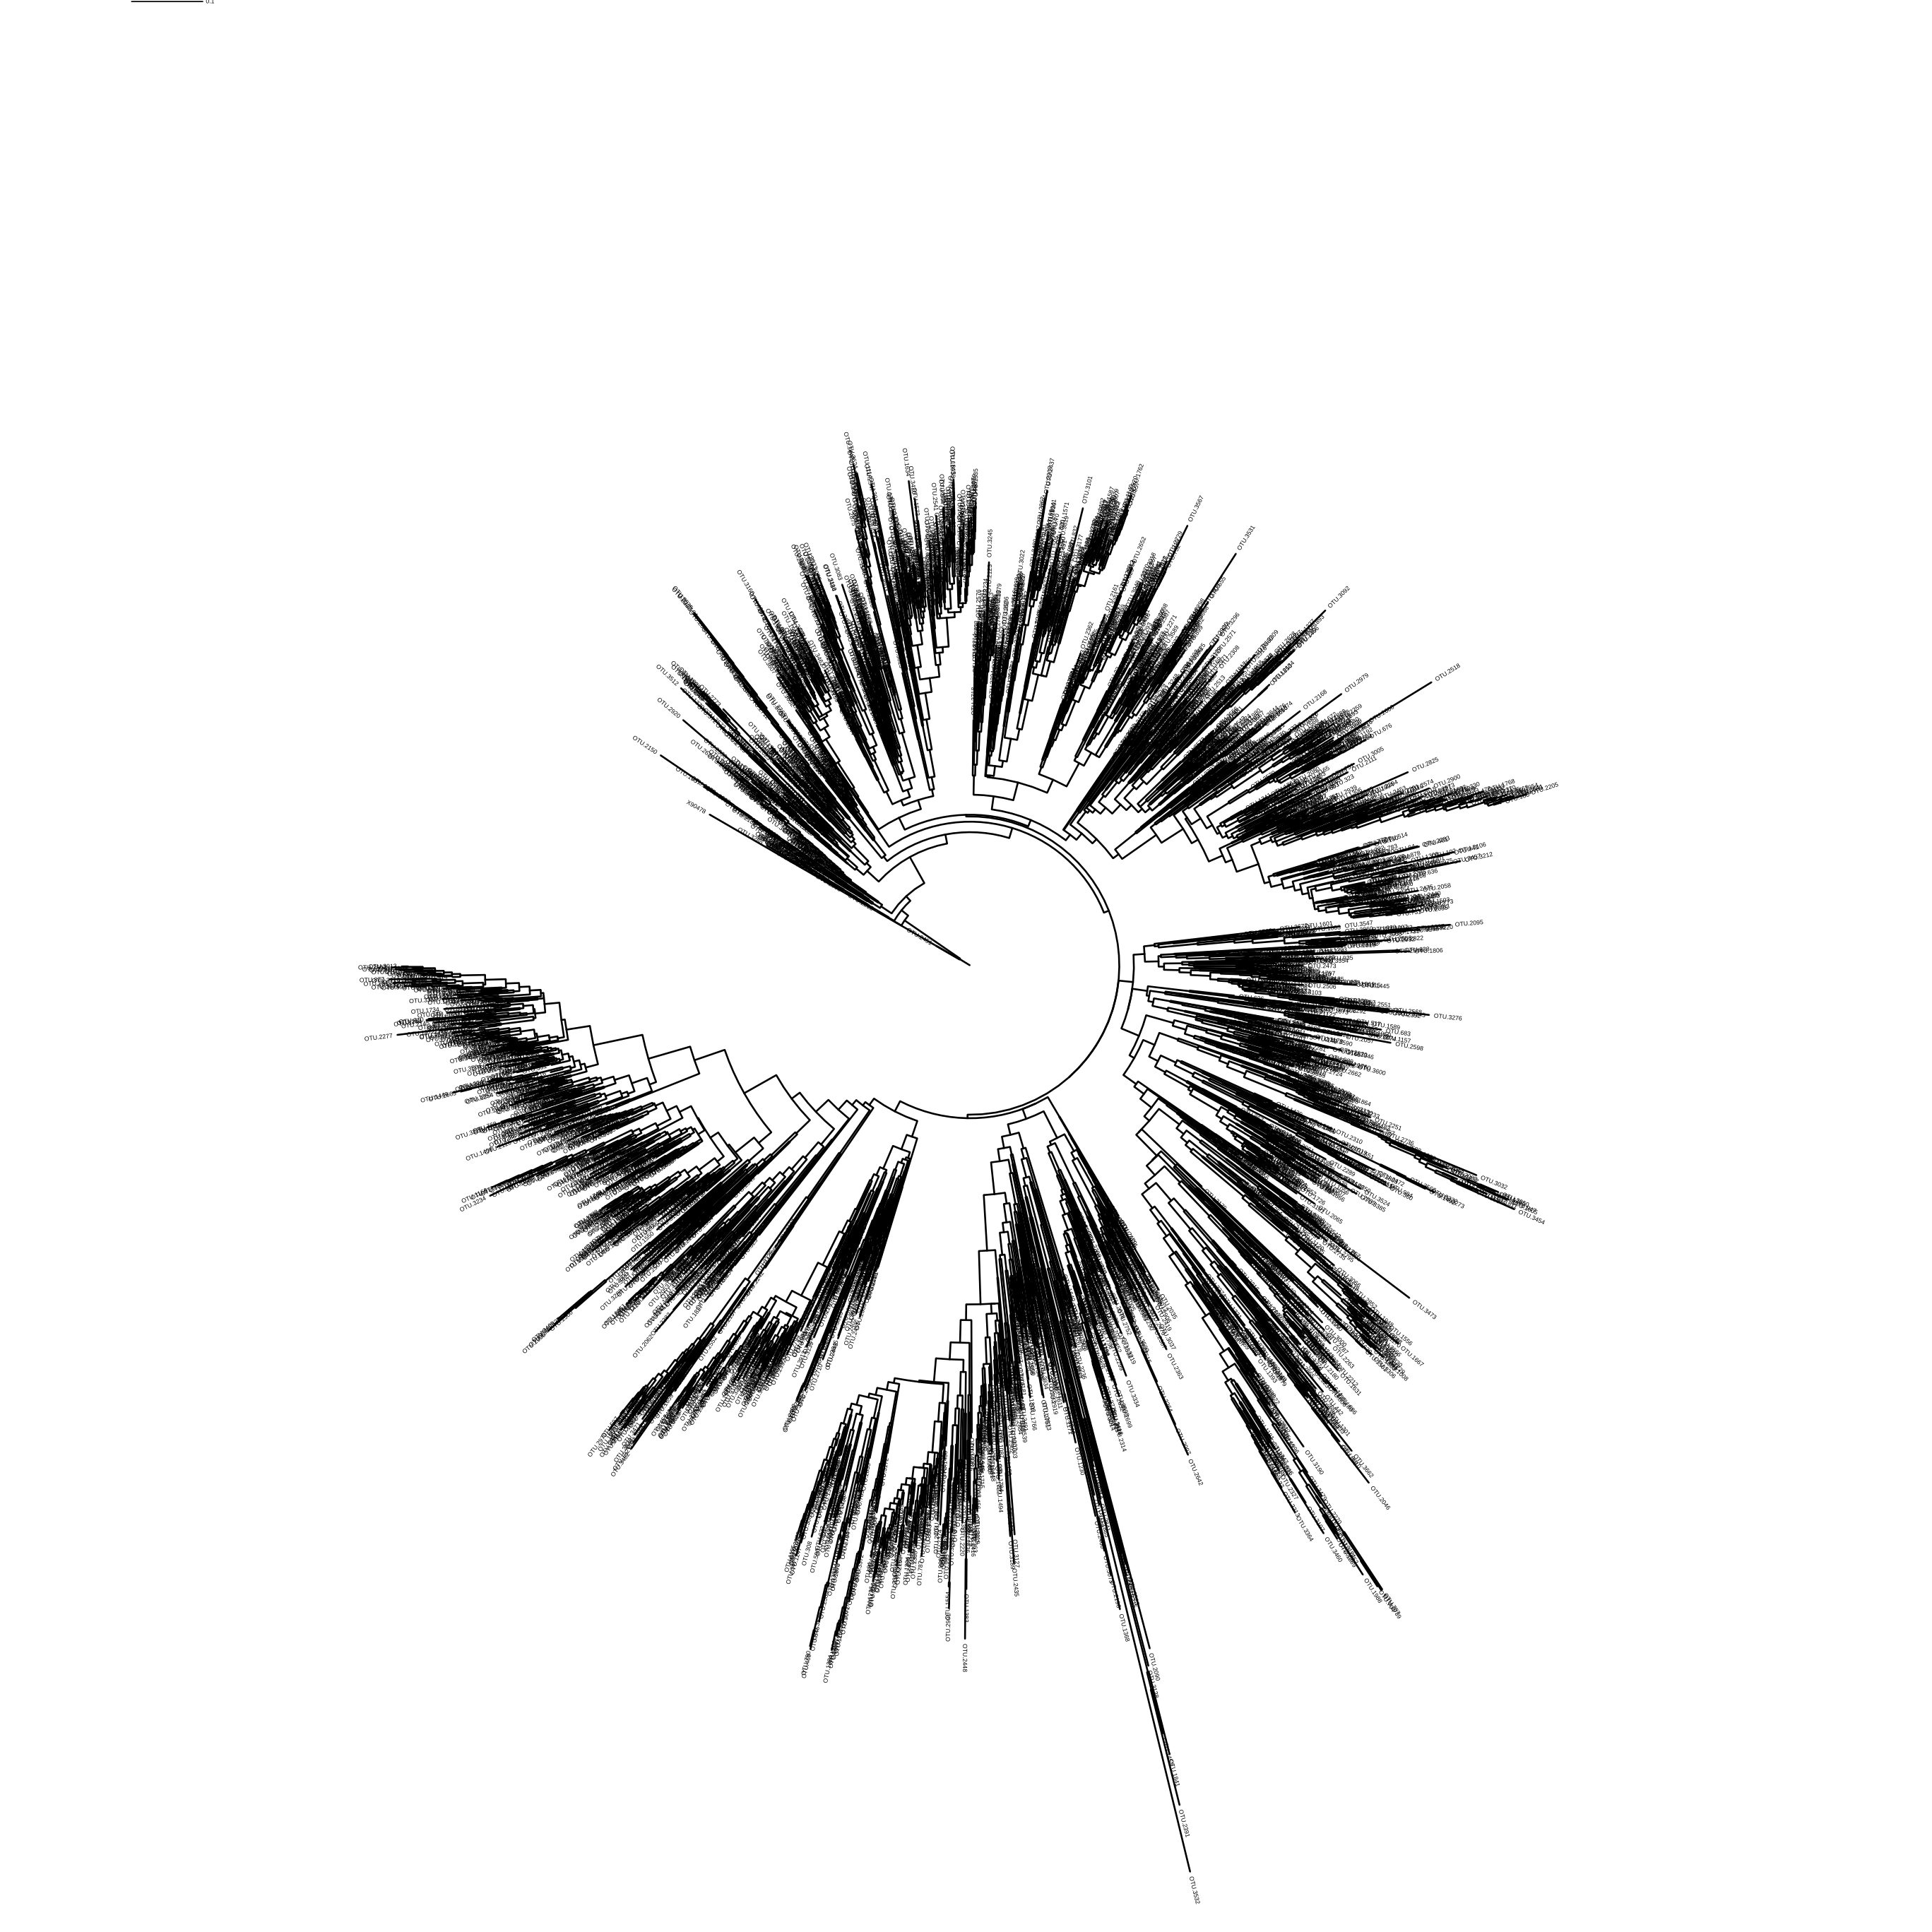

In [22]:
i = Image(filename="data/otusn_SON.tree.png", width=600)
display(i)